In [2]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from glob import glob 
import os
from tabulate import tabulate

#  Noise floor estimation

using repetitive image acquisition without change

In [3]:
def load_image(path):
    """ Load the image at the given path
         returns 2d array (float)
         convert to grayscale if needed
    """
    try:
        I = io.imread(path)
        # Convert to grayscale if needed:
        I = I.mean(axis=2) if I.ndim == 3 else I
        I = I.astype(np.float)
    except FileNotFoundError:
        print("File %s Not Found" % path)
        I = None

    return I

In [4]:
def build_grid(img_shape, margin, grid_spacing):
    """Build a regular grid
    
    Args:
        img_shape: tuple shape of the image (Int, Int)
        margin: size of the margin in px
        grid_spacing: spacing in px between points
        
    Returns:
        x_grid, y_grid: 2d arrays of coordinates
    """
    x_span = np.arange(0, img_shape[1]-2*margin, grid_spacing)
    y_span = np.arange(0, img_shape[0]-2*margin, grid_spacing)
    
    x_offset = int( (img_shape[1] - x_span[-1])/2 )
    y_offset = int( (img_shape[0] - y_span[-1])/2 )    
    
    x_grid, y_grid = np.meshgrid(x_span + x_offset, y_span + y_offset)
    
    print("grid size:", "%ix%i" % (len(x_span), len(y_span)))
    print(" i.e.", len(x_span)*len(y_span), "points")

    return x_grid, y_grid

In [5]:
dirs = glob('./images/*/')
print(tabulate(enumerate(dirs)))

-  ------------------
0  ./images/hs2_4p0/
1  ./images/hs2_5p0/
2  ./images/ss2_0p2/
3  ./images/hpr1_0p5/
4  ./images/spp2_0p0/
5  ./images/vermeer/
6  ./images/hs2_50p0/
7  ./images/ss2_2p0/
-  ------------------


In [6]:
dir_name = dirs[0]
images_list = glob(dir_name + '*')

print(', '.join(images_list))
print(len(images_list))

./images/hs2_4p0/hs24p000183.TIF, ./images/hs2_4p0/hs24p000188.TIF, ./images/hs2_4p0/hs24p000189.TIF, ./images/hs2_4p0/hs24p000186.TIF, ./images/hs2_4p0/hs24p000184.TIF, ./images/hs2_4p0/hs24p000179.TIF, ./images/hs2_4p0/hs24p000180.TIF, ./images/hs2_4p0/hs24p000182.TIF, ./images/hs2_4p0/hs24p000181.TIF, ./images/hs2_4p0/hs24p000185.TIF, ./images/hs2_4p0/hs24p000187.TIF
11


In [7]:
# Load image cube
cube = []
for k, img_path in enumerate(images_list):
    image = load_image(img_path)
    cube.append(image)

cube = np.dstack( cube )
print('cube', cube.shape)

cube (1024, 1392, 11)


grid size: 24x17
 i.e. 408 points


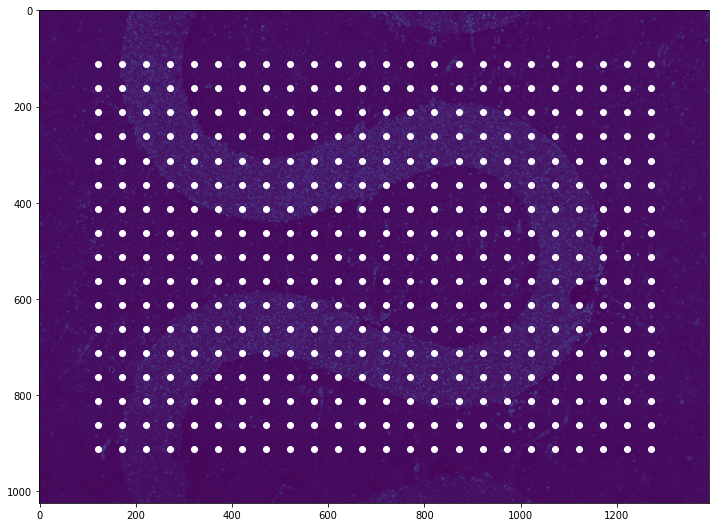

In [8]:
# Define grid
grid_x, grid_y = build_grid(cube.shape[:2], 100, 50)

plt.figure(figsize=(12, 12))
#plt.imshow(np.mean(cube[:, :, 0]+cube[:, :, 1]);
plt.imshow(np.std(cube, axis=2));
plt.plot(grid_x, grid_y, 'o', color='white');

In [9]:
from skimage.registration import phase_cross_correlation

In [10]:
def crop(I, ij_center, window_half_size):
    """Return the centered square at the position"""

    ij_center = np.around(ij_center).astype(np.int)
    i, j = ij_center
    i_slicing = np.s_[i - window_half_size:i + window_half_size + 1]
    j_slicing = np.s_[j - window_half_size:j + window_half_size + 1]

    return I[i_slicing, j_slicing]

## map displacement field between **two images**

In [20]:
# Choose two images:
image_i, image_j = 4, 7
upsample_factor = 500
size = 30  # window size used for cross-corr

In [26]:
dx = np.zeros_like(1.0*grid_x)
dy = np.zeros_like(1.0*grid_y)

for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        x, y = grid_x[i, j], grid_y[i, j]
        
        I = crop(cube[:, :, image_i], (y, x), size)
        J = crop(cube[:, :, image_j], (y, x), size)
        shifts, error, _ = phase_cross_correlation(I, J,
                                                   upsample_factor=upsample_factor)
        
        dx[i, j] = shifts[1]
        dy[i, j] = shifts[0]

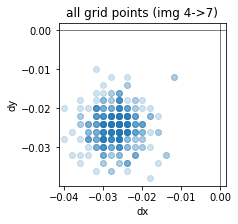

In [27]:
plt.figure(figsize=(3, 3)); plt.title('all grid points' + f' (img {image_i}->{image_j})')
plt.plot(dx.flatten(), dy.flatten(), 'o', alpha=0.2)
plt.axvline(x=0, linewidth=0.5, color='black');
plt.axhline(y=0, linewidth=0.5, color='black');
plt.axis('equal');
plt.xlabel('dx'); plt.ylabel('dy');

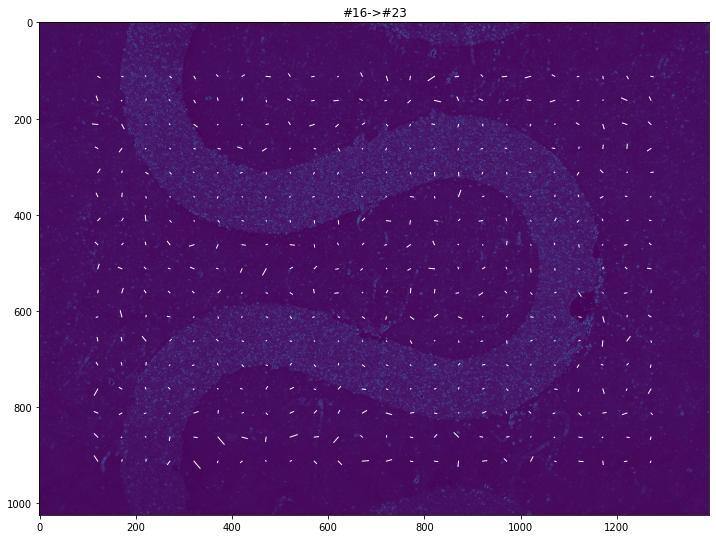

In [28]:
# Map
view_factor = 1000   # magnifcation factor used to draw the vector field

plt.figure(figsize=(12, 12))
#plt.imshow(np.mean(cube[:, :, 0]+cube[:, :, 1]);
plt.imshow(np.std(cube, axis=2));
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
    
        x, y = grid_x[i, j], grid_y[i, j]
        u, v = dx[i, j]-dx.mean(), dy[i, j]-dy.mean()

        plt.plot([x, x + view_factor*v],
                 [y, y + view_factor*u],
                 '-', color='white', linewidth=1);
    
plt.title(f'#{i}->#{j}');

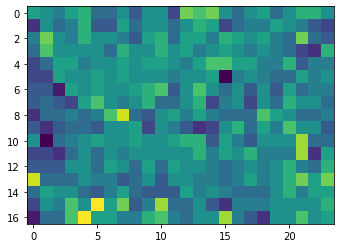

In [15]:
plt.imshow(dx-dx.mean())

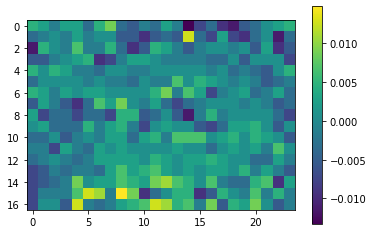

In [16]:
plt.imshow(dy-dy.mean()); plt.colorbar();

In [17]:
print( dx.mean(), dx.std() )
print( dy.mean(), dy.std() )

-0.02695588235294118 0.004237786916179657
-0.024759803921568627 0.004421555041064297


## i->j matrix

In [32]:
def compute_dxy_matrix(stack, upsample_factor=100):
    n = stack.shape[2]
    dx = np.full((n, n), np.nan)
    dy = np.full((n, n), np.nan)
    
    for i in range(n):
        for j in range(i+1, n):
            I = stack[:, :, i]
            J = stack[:, :, j]
            shifts, error, _ = phase_cross_correlation(I, J,
                                                    upsample_factor=upsample_factor)

            dx[i, j] = shifts[0]
            dy[i, j] = shifts[1]
            #print(f'{i: d}, {j: d}', shifts)
            
    return dx, dy

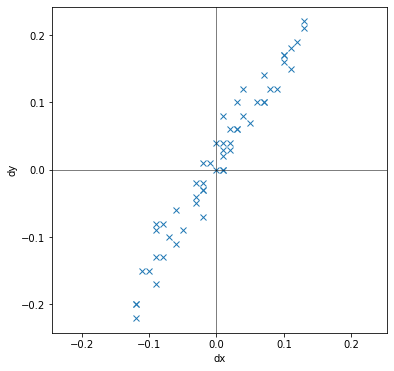

In [33]:
stack = crop(cube, (800, 370), 30)
dx, dy = compute_dxy_matrix(stack)

plt.figure(figsize=(6, 6));
plt.axis('equal');
plt.plot(dx.flatten(), dy.flatten(), 'x');
plt.axvline(x=0, linewidth=0.5, color='black');
plt.axhline(y=0, linewidth=0.5, color='black');
plt.axis('equal');
plt.xlabel('dx'); plt.ylabel('dy');

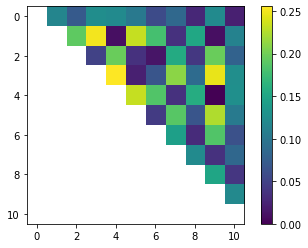

In [34]:
dr = np.sqrt(dx**2 + dy**2)
plt.imshow(dr); plt.colorbar();

il y a un bruit, ou dérive, de l'ordre de 0.1px pour les images

 - hs2 --> plutôt une dérive
 - 
 
 
* bruit acquisition + crop size (<10-20px) --> similar to fit noise
* sample drift:
    - non isotrope!
    - semble homogene sur la surface --> vibration caméra/échantillon plutôt que relax de l'échantillon


--> error estimation based on multiple image acquisition (vs gausian additive noise) 

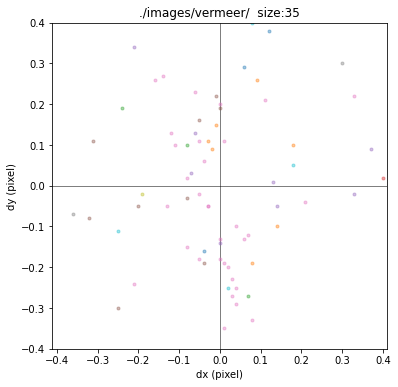

In [45]:
## pour tout les points de la grille:
size = 35

plt.figure(figsize=(6, 6));
plt.axis('equal');
plt.axvline(x=0, linewidth=0.5, color='black');
plt.axhline(y=0, linewidth=0.5, color='black');
plt.xlabel('dx (pixel)'); plt.ylabel('dy (pixel)');
plt.title(dir_name + f'  size:{size}')

for x, y in zip(grid_x.flatten(), grid_y.flatten()):
    
    stack = crop(cube, (y, x), size)
    dx, dy = compute_dxy_matrix(stack)
    plt.plot(dx.flatten(), dy.flatten(), '.', alpha=0.4);

plt.xlim([-0.4, 0.4]); plt.ylim([-0.4, 0.4]);  
plt.savefig(os.path.join('output', dir_name.split('/')[-2] + f'_size{size}.svg'))